In [683]:
import numpy as np
import pandas as pd
import pickle
import os
import sys
from pathlib import Path
from haversine import haversine

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [684]:
sys.path.append('./utils/')
import functions
import variables

# Summary
- In this notebook is the full 'memory' of this machine learning project to build interpretable machine learning models to predict and understand the anual cereal yields by country.
- This project seeks to build an interpretable regression model and will use both linear regression and random forest regression where we will look to sacrifice accuracy of the model for interpretability.

- The overview of the steps are:
    - Load data from World Bank, incuding our target of Cereal Yield.
    - Transform and fill missing values
    - Merge this with other datasets from other sources.
    - Final feature selection and engineering.
    - Build first simple linear regression models with minimal features and testing polynomial degrees.
    - Add in rest of features and assess improvements.
    - Compare with Random Forest Regression

# Load, assess and preprocess World bank data

In [685]:
path = './misc/world_bank_data/'

wb_df = pd.DataFrame(columns=['Country Name', 'Country Code',  'Year'])

for root, subdirs, files in os.walk(path):
    for file in files:
        if file.startswith('API'):
            df_variable = functions.world_bank_data_load_melt(root + '/' + file)
            wb_df = wb_df.merge(df_variable, how = 'outer')

In [686]:
wb_df.head()

,Country Name,Country Code,Year,Cereal yield (kg per hectare),Investment in transport with private participation (current US$),"Employment in agriculture, male (% of male employment) (modeled ILO estimate)","Employment in agriculture, female (% of female employment) (modeled ILO estimate)",Arable land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)","Renewable internal freshwater resources, total (billion cubic meters)",Arable land (hectares per person),Permanent cropland (% of land area),Energy intensity level of primary energy (MJ/$2017 PPP GDP),"Annual freshwater withdrawals, total (billion cubic meters)",Fertilizer consumption (kilograms per hectare of arable land),"Government expenditure on education, total (% of GDP)","Agricultural machinery, tractors per 100 sq. km of arable land",Total natural resources rents (% of GDP),Agricultural irrigated land (% of total agricultural land)
0,Aruba,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### We are not interested in any rows that do not contain the target value

In [687]:
wb_df = wb_df.dropna(subset = ['Cereal yield (kg per hectare)'])

#### Nor do we want the geographic regions or country groups used in the world bank data

In [688]:
wb_df = wb_df[~wb_df['Country Name'].isin(variables.non_countries)]

In [689]:
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9561 entries, 268 to 16225
Data columns (total 19 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Country Name                                                                       9561 non-null   object 
 1   Country Code                                                                       9561 non-null   object 
 2   Year                                                                               9561 non-null   object 
 3   Cereal yield (kg per hectare)                                                      9561 non-null   float64
 4   Investment in transport with private participation (current US$)                   541 non-null    float64
 5   Employment in agriculture, male (% of male employment) (modeled ILO estimate)      4929 non-null   fl

In [690]:
wb_df['Year'] = wb_df['Year'].astype(int)

#### Remove variables with too many missing values

In [691]:
wb_df = functions.drop_too_many_missing(wb_df, 60)

In [692]:
wb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9561 entries, 268 to 16225
Data columns (total 16 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   Country Name                                                                       9561 non-null   object 
 1   Country Code                                                                       9561 non-null   object 
 2   Year                                                                               9561 non-null   int64  
 3   Cereal yield (kg per hectare)                                                      9561 non-null   float64
 4   Employment in agriculture, male (% of male employment) (modeled ILO estimate)      4929 non-null   float64
 5   Employment in agriculture, female (% of female employment) (modeled ILO estimate)  4929 non-null   fl

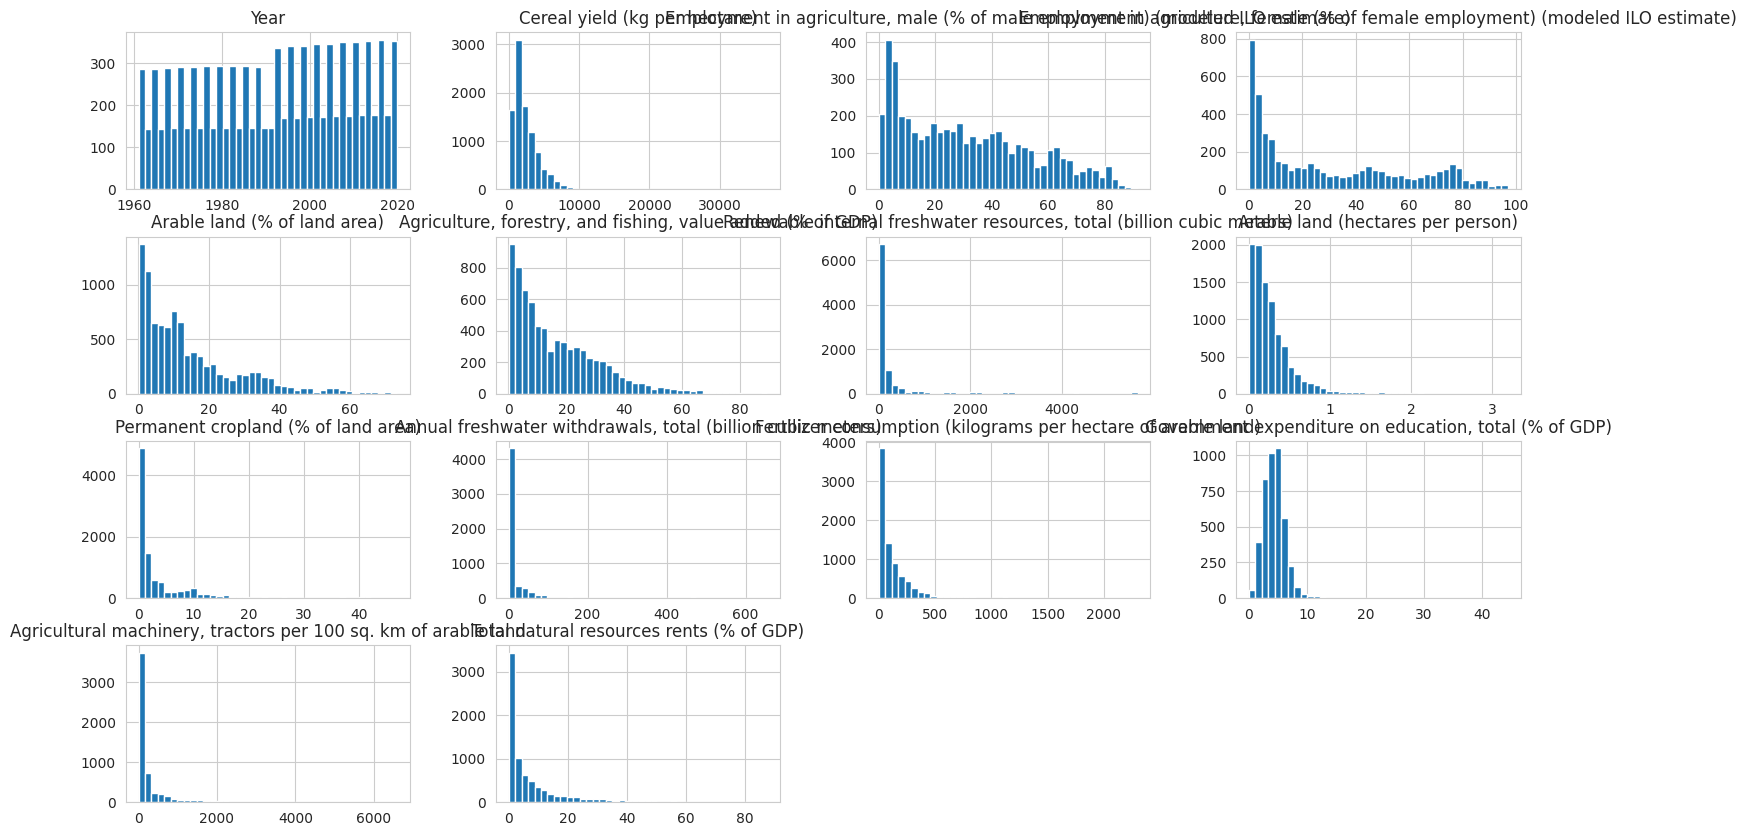

In [693]:
wb_df.hist(bins = 40, figsize = (18, 10));

#### Log transform should help make all variables and target more normal

In [694]:
log_wb_df = functions.log_transform_data(wb_df, ['Year'])

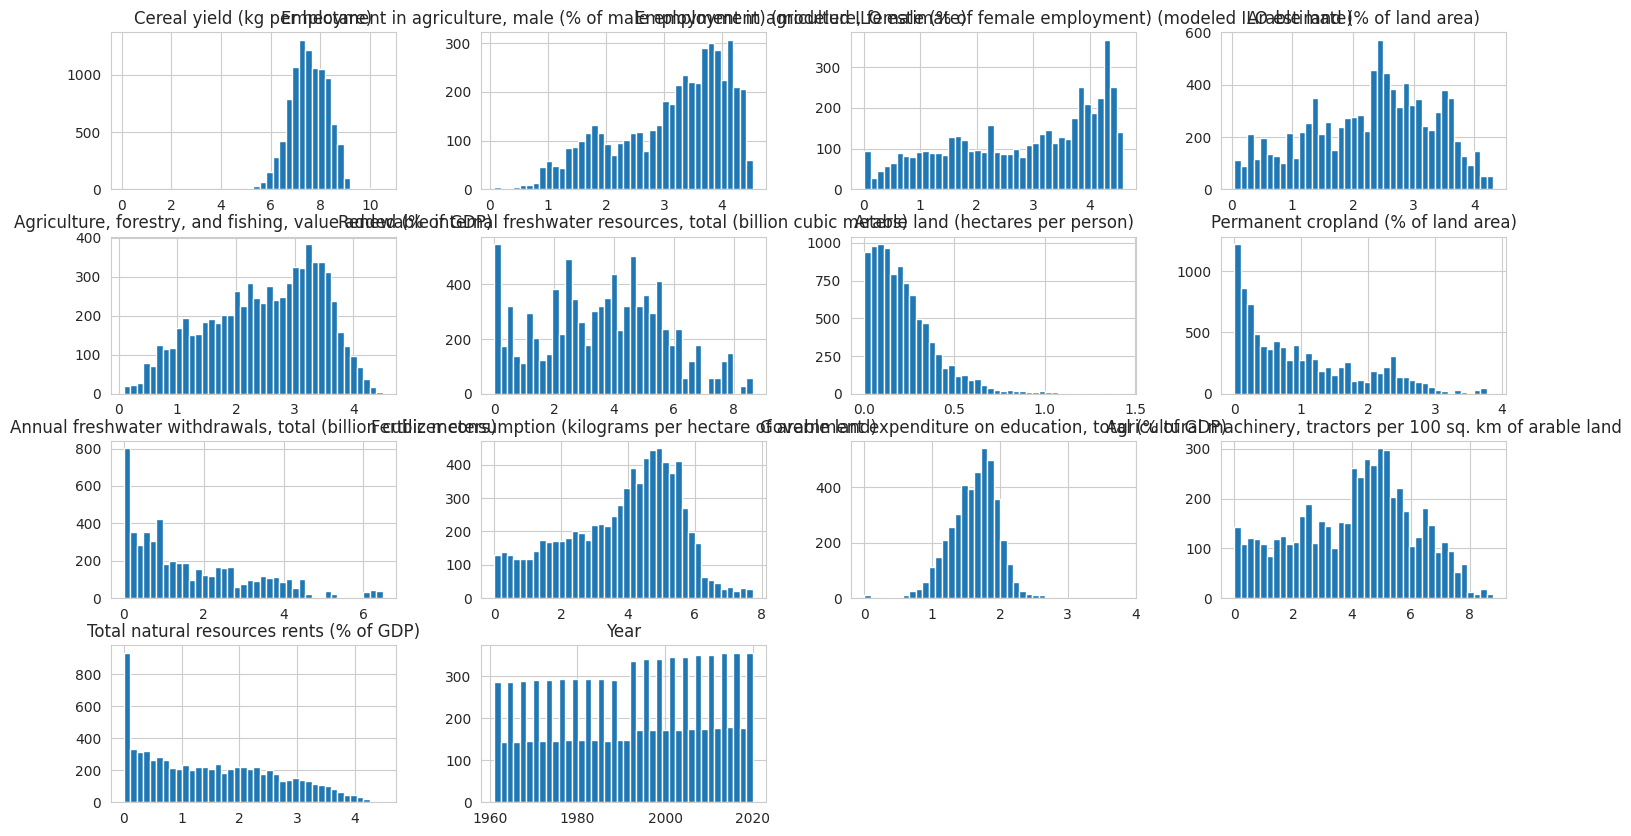

In [695]:
log_wb_df.hist(bins = 40, figsize = (18, 10));

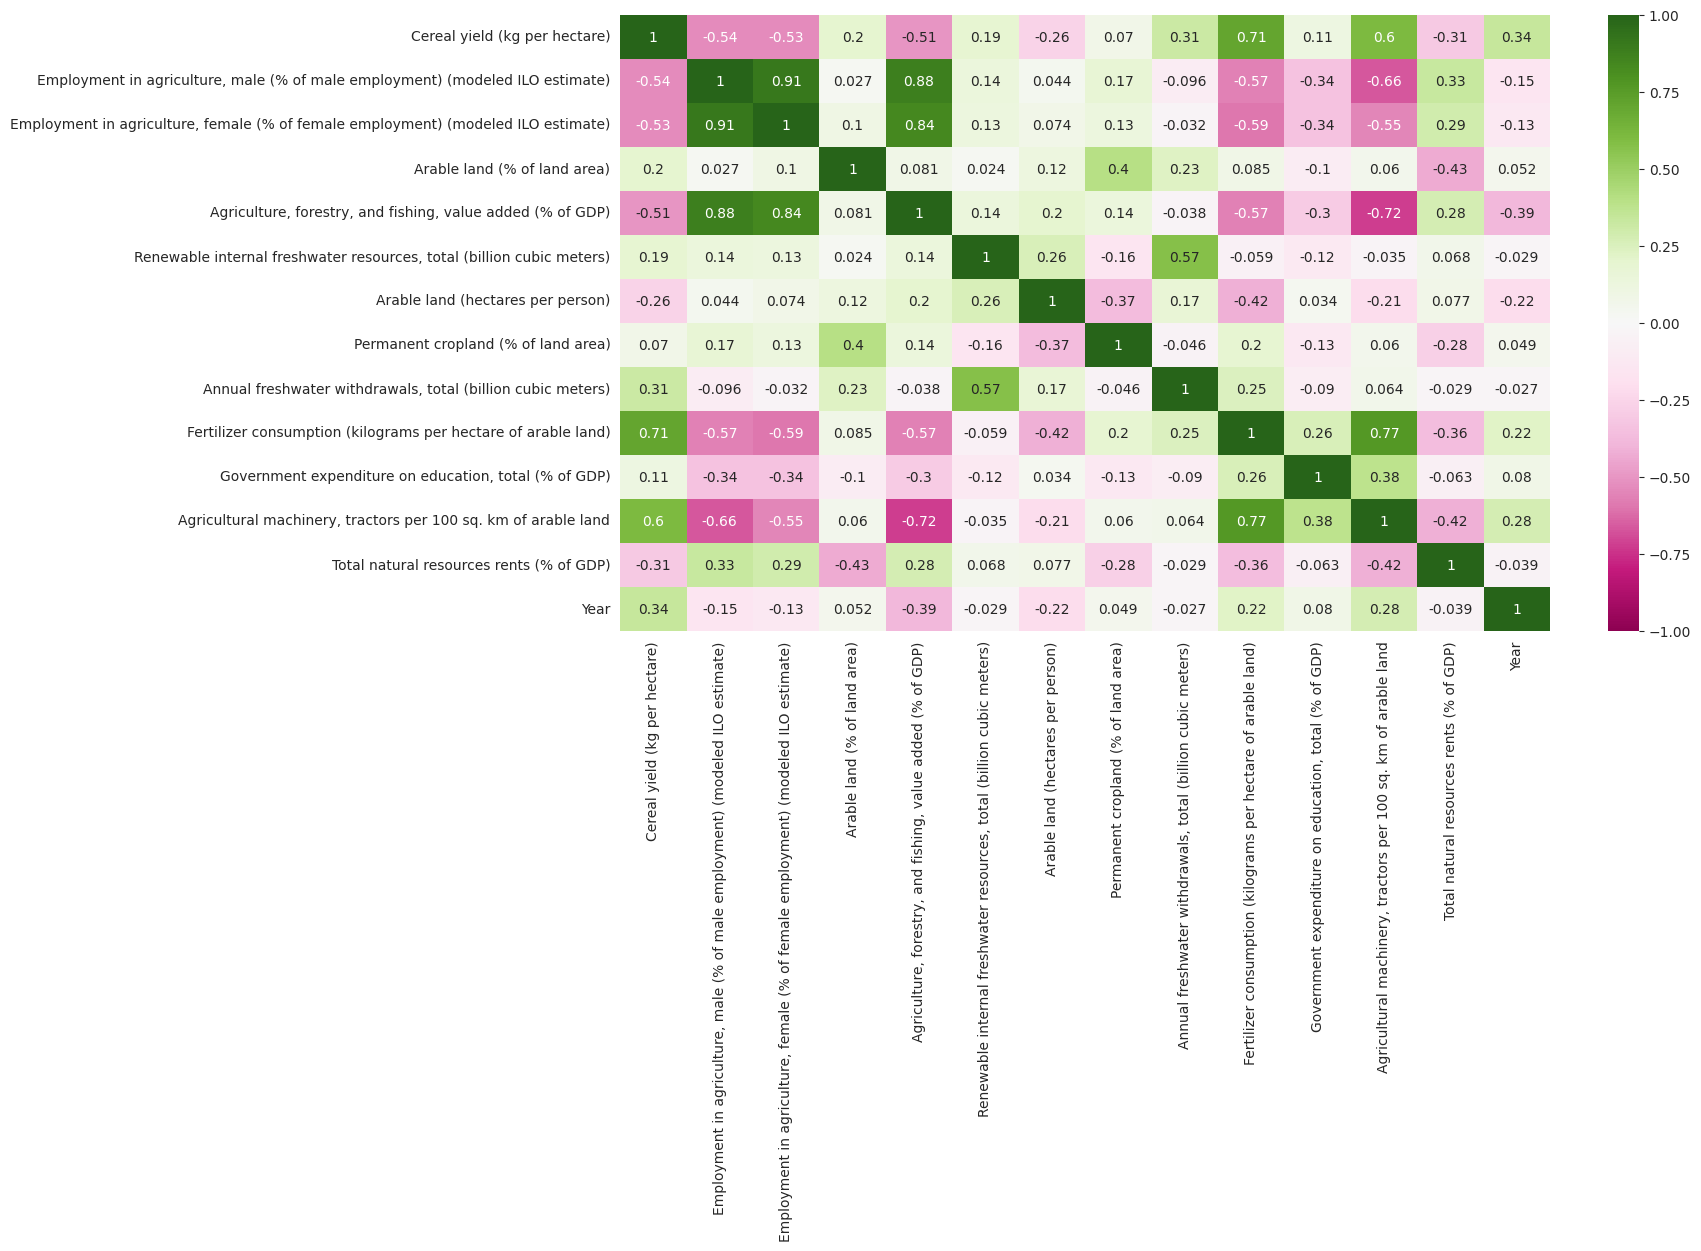

In [696]:
fig, ax = plt.subplots(figsize = (15, 8))
sns.heatmap(log_wb_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG');

#### Drop variables that have high correlation with other variables or with no correlation with target

In [697]:
log_wb_df = log_wb_df.drop(columns = ['Agricultural machinery, tractors per 100 sq. km of arable land',
                              'Employment in agriculture, male (% of male employment) (modeled ILO estimate)',
                              'Employment in agriculture, female (% of female employment) (modeled ILO estimate)', 
                              'Permanent cropland (% of land area)',
                              'Renewable internal freshwater resources, total (billion cubic meters)'])

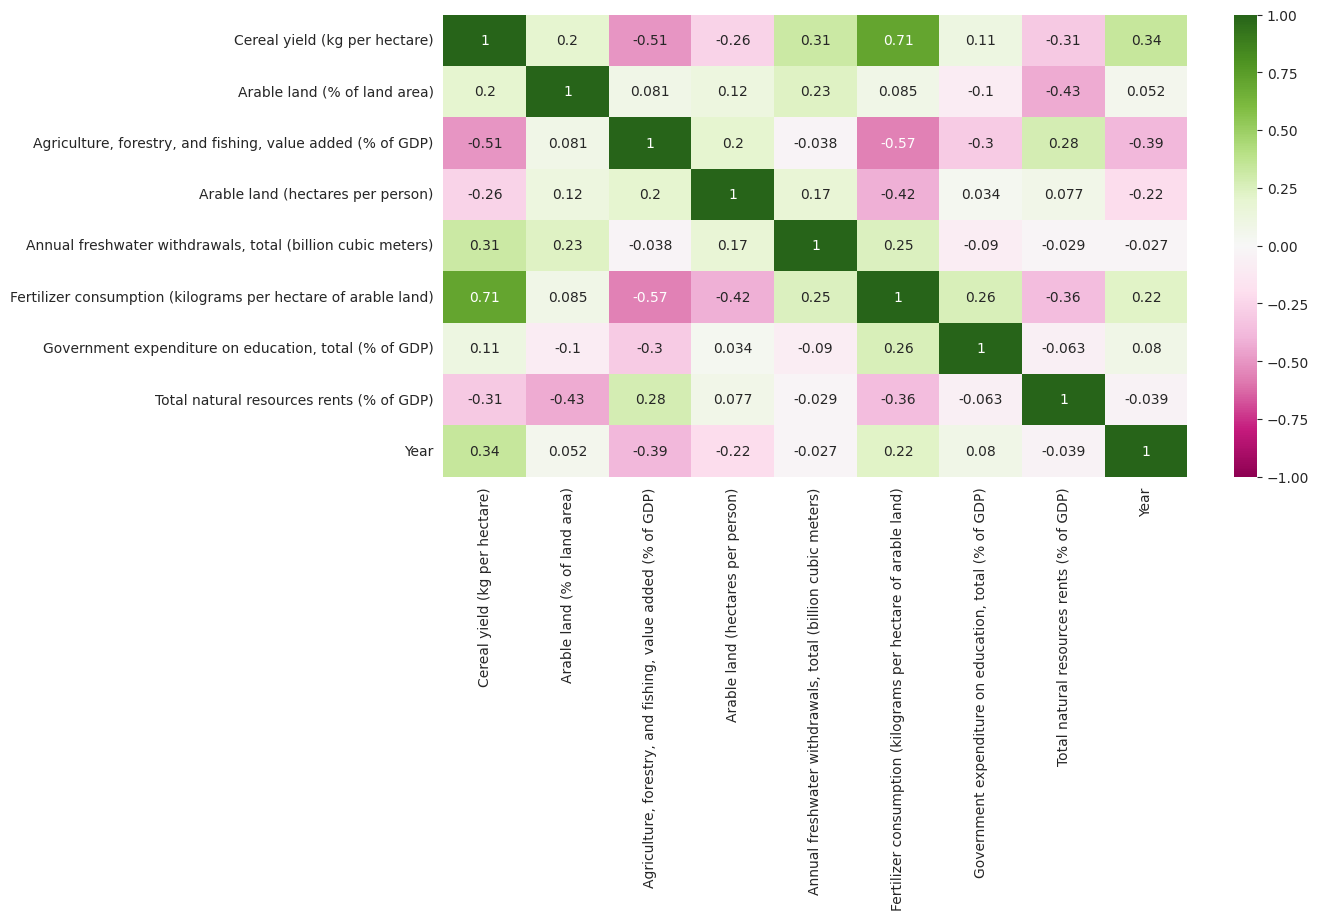

In [698]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(log_wb_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG');

#### So we are left with:
- Year - an expected but not very strong +ve correlation with the cereal yield showing time component
- %arable land - this could indicate the overall fertility of a country
- %GDP rural economy - this reflects the general level of development of a country with higher values representing lower development
- Arable land per person - with a higher population per arable land area there is greater pressure on the land to produce and so productivity has increased?
- Freshwater withdrawls - as more water has been extracted, agriculture output has been able to increase being a fundamental input
- fertilizer - this shows a clear link and is a proxy for inputs that drive productivity
- %GDP education - this should have a delayed but at least weak positive impact on productivity leading to greater research
- %GDP natural resources rent - this is another angle on development with countries that rely more on natural resources to support their economy instead of moving through manufacturing and or service industries

#### Dealing with missing values

In [699]:
log_wb_df = log_wb_df.sort_values(by = ['Country Name', 'Year'])

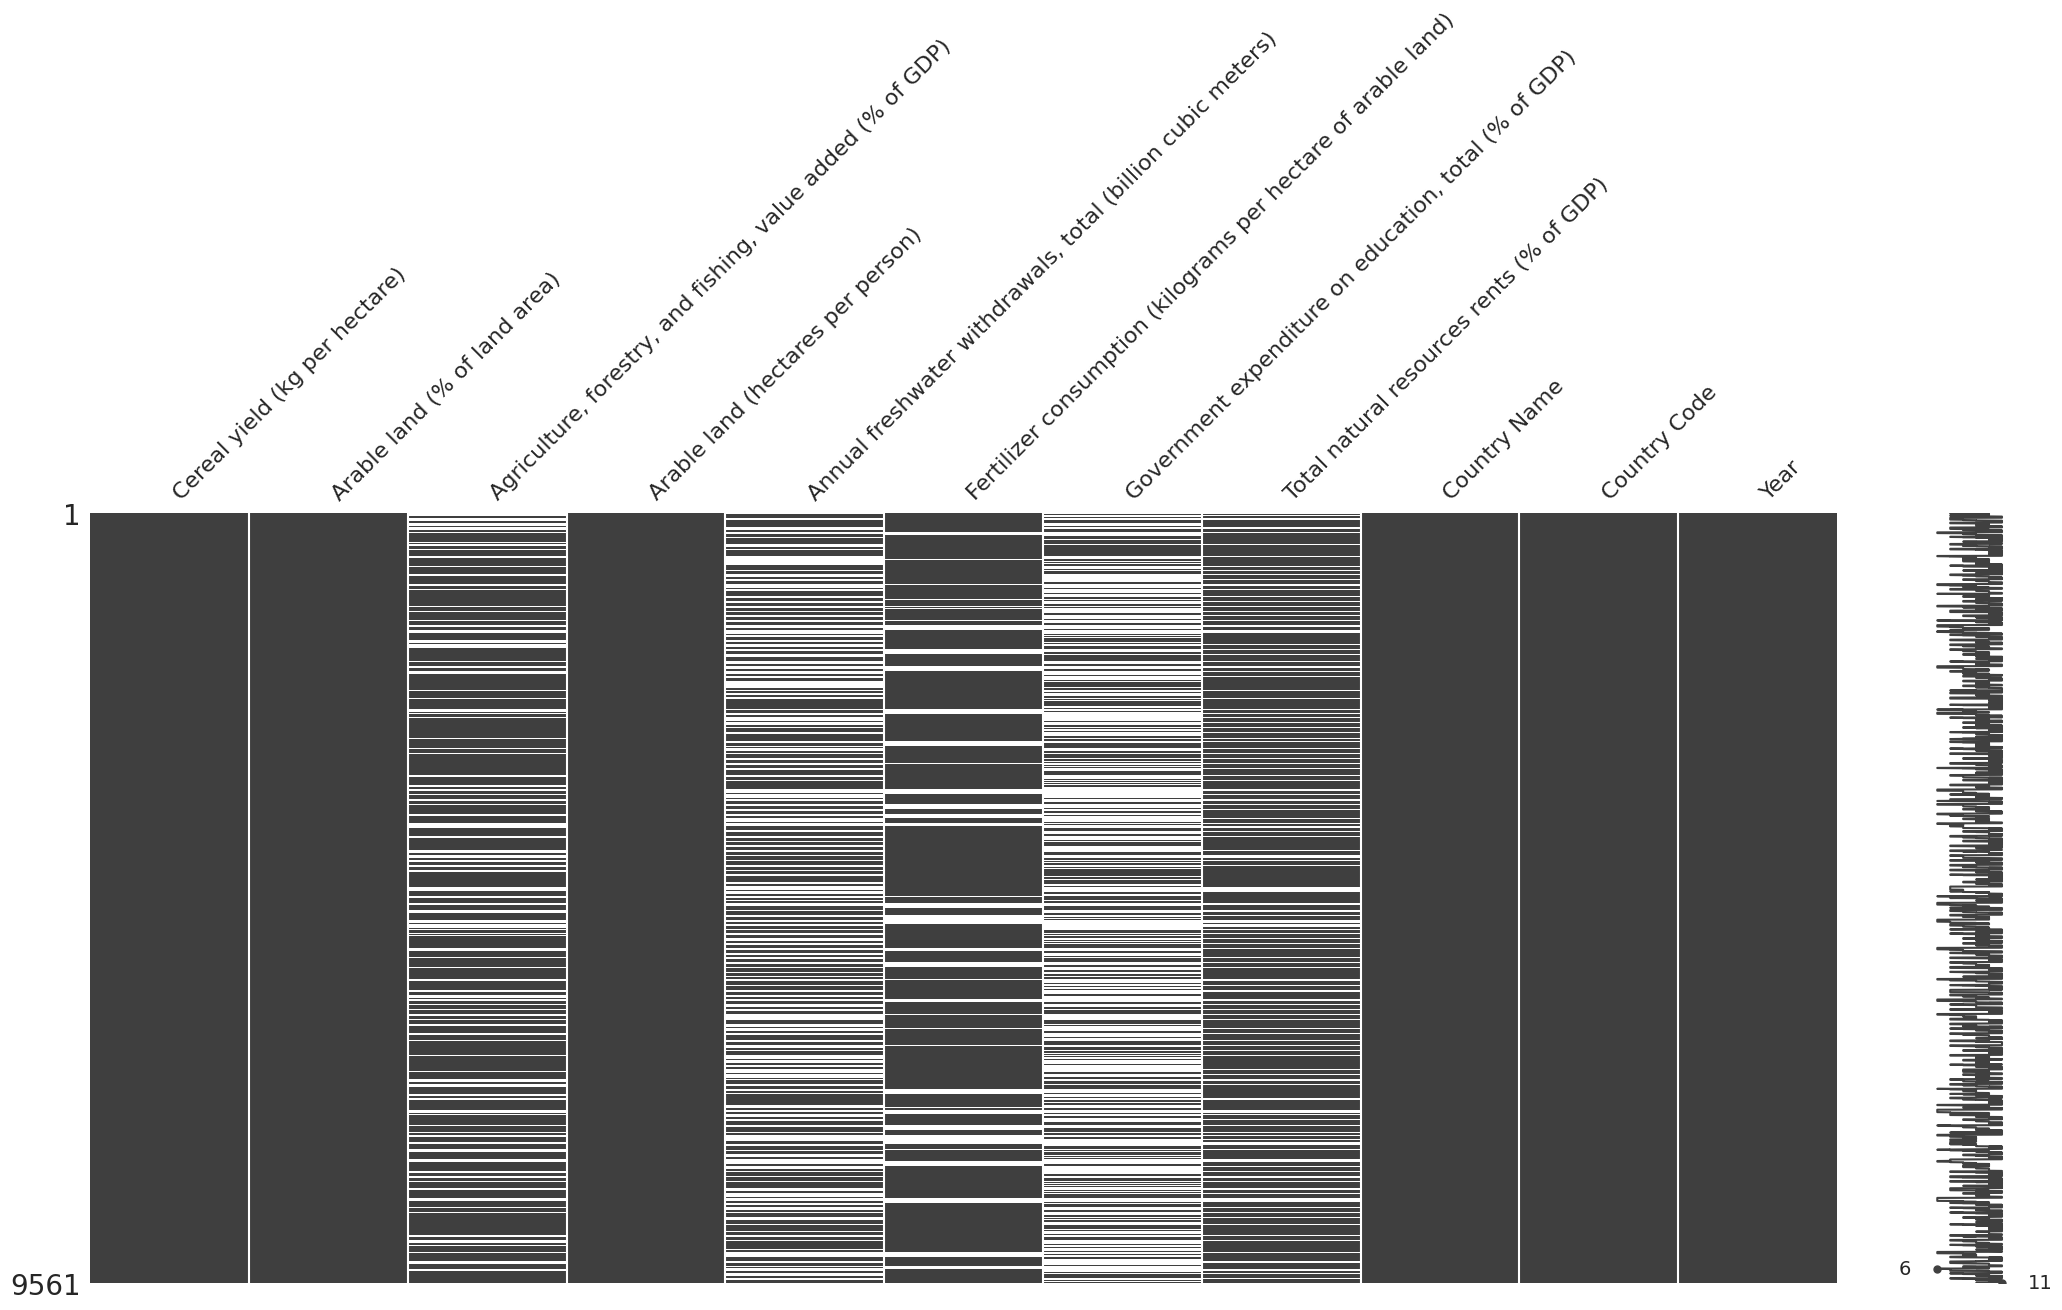

In [700]:
msno.matrix(log_wb_df);

#### Most of the missing data in concentrated in the 1960's so we will drop all rows before 1970

In [701]:
log_wb_df = log_wb_df[log_wb_df['Year'] > 1969]

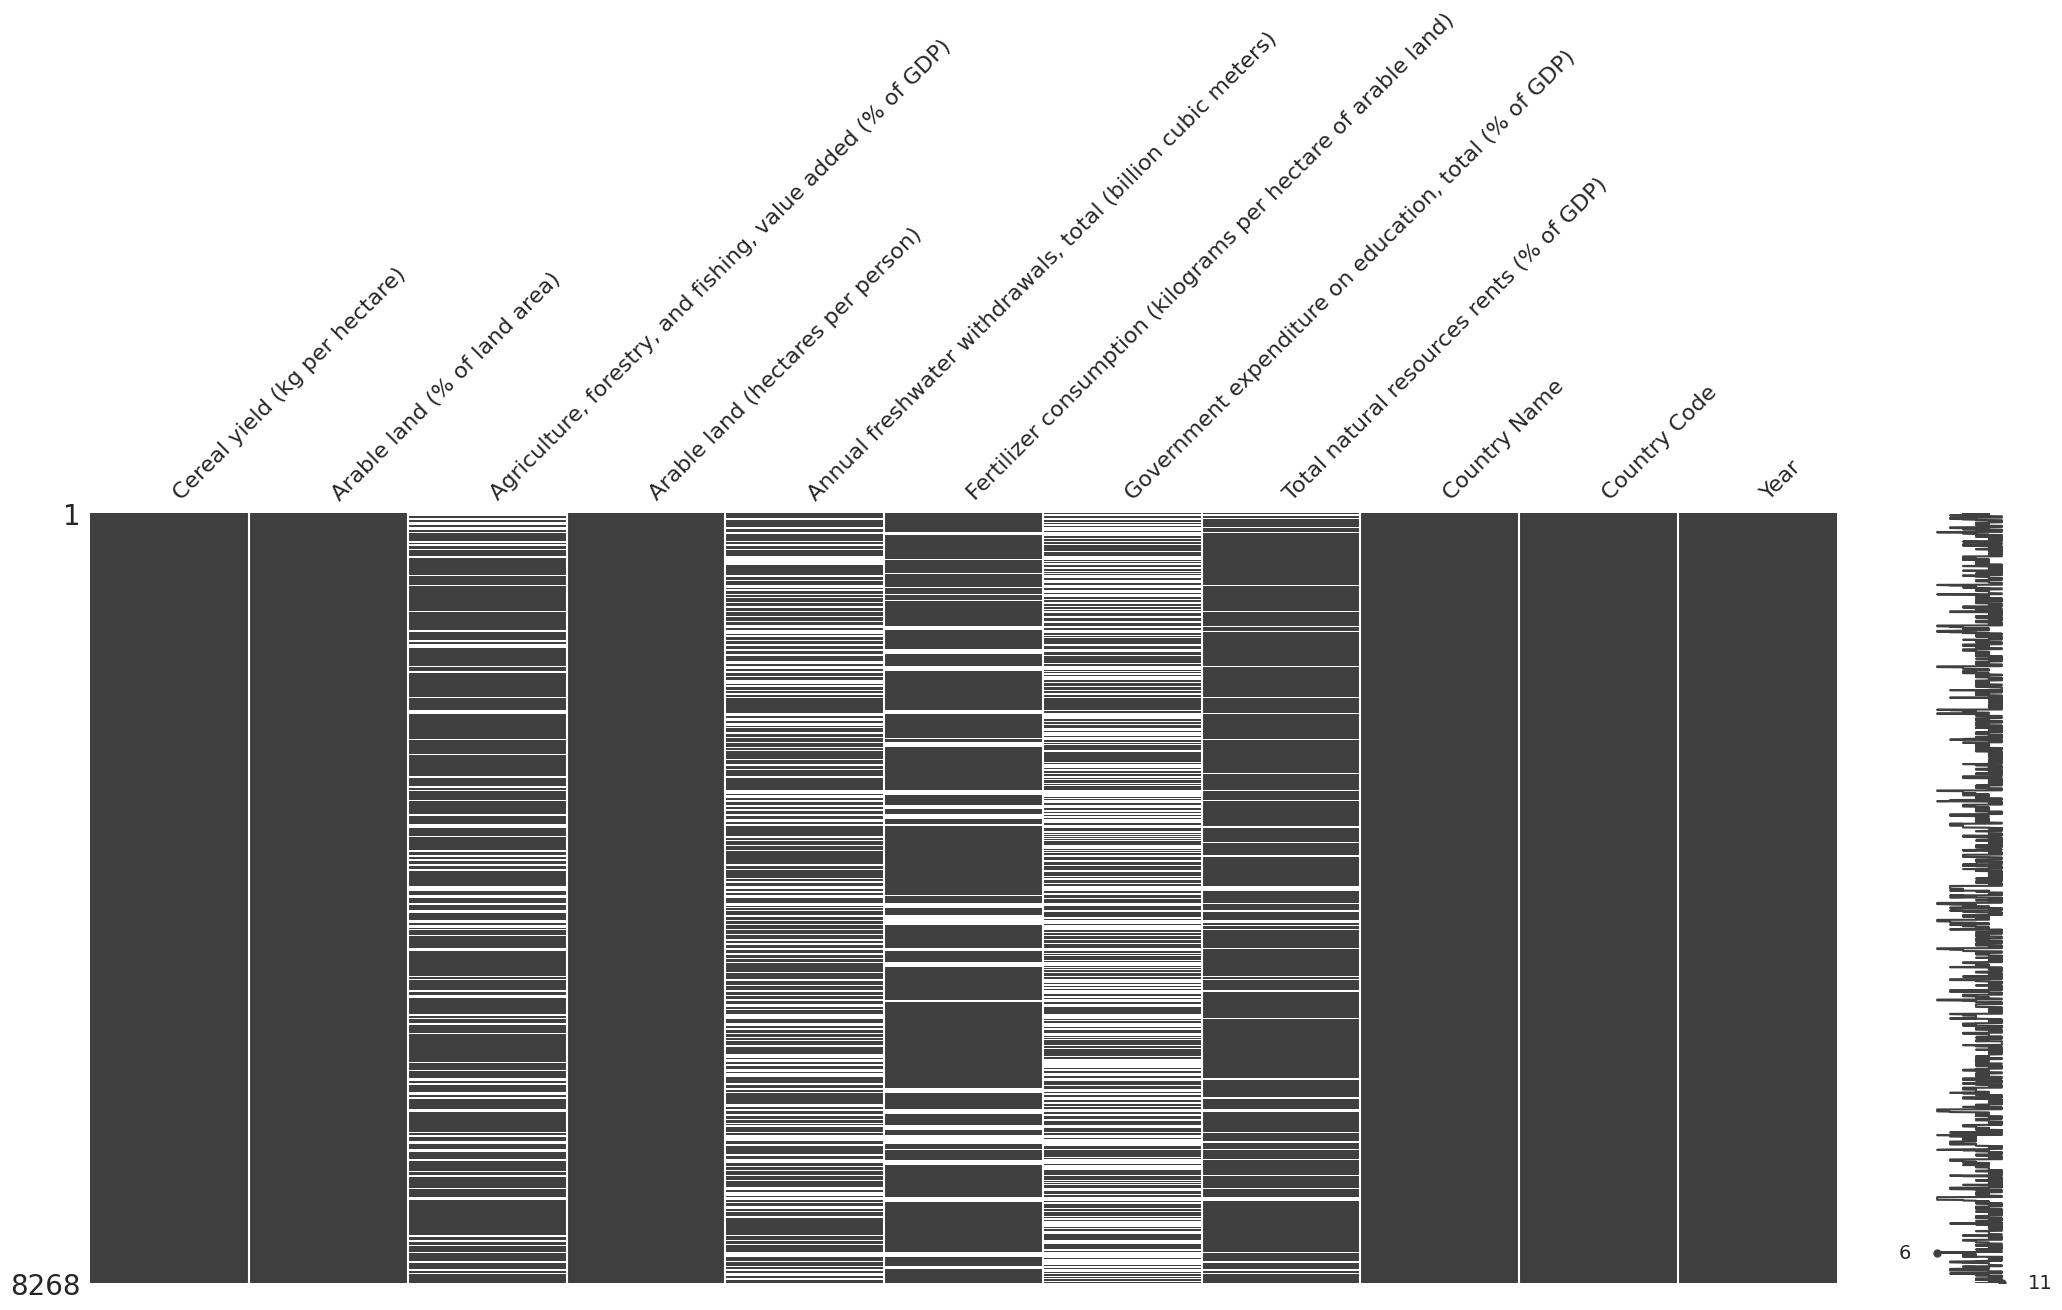

In [702]:
msno.matrix(log_wb_df);

#### Now we will do a ffill for each country to try reduce the NaN's
Doing a forward fill at this stage will not contaminate train with test

In [703]:
before_ffill = (pd.DataFrame(log_wb_df.isnull().sum() * 100 / len(log_wb_df))
                .sort_values(by = 0, ascending = False)
                .rename(columns = {0: 'Before ffill'})
                .reset_index())

In [704]:
for col in log_wb_df.columns:
    if log_wb_df[col].dtype == 'float64':
        log_wb_df[col] = log_wb_df.groupby('Country Name')[col].transform(lambda x: x.ffill())

In [705]:
after_ffill = (pd.DataFrame(log_wb_df.isnull().sum() * 100 / len(log_wb_df))
                .sort_values(by = 0, ascending = False)
                .rename(columns = {0: 'After ffill'})
                .reset_index())

In [706]:
ffill_results = pd.merge(before_ffill, after_ffill, on = 'index')

In [707]:
ffill_results = ffill_results.melt(id_vars = 'index', value_name = 'Percent')

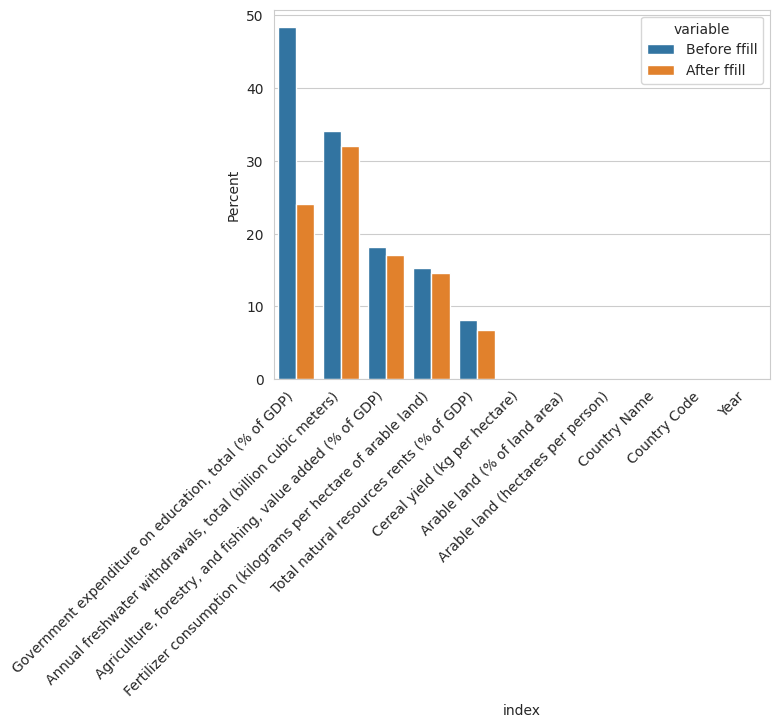

In [708]:
sns.barplot(data = ffill_results, x = 'index', y = 'Percent', hue = 'variable')
plt.xticks(rotation = 45, ha = 'right');

#### Finally we will rename this columns

In [709]:
# rename for ease of use downstream
log_wb_df.columns = ['Cereal_Yield', 'Arable_Land_Percent', 'Value_Added_AFF', 'Arable_Land_Person', 'Freshwater_Withdrawl', 'Fertilizer', 'Education_Expenditure', 'Natural_Resource_Rents', 'Country_Name', 'Country_Code', 'Year', ]

# Adding in other datasets

In [710]:
country_latitude_longitude = pd.read_csv("./misc/Country_lat_long.csv")
historical_mean_temperature = pd.read_csv("./misc/temp.csv")
historical_gdp = pd.read_csv('./misc/gdp-per-capita-maddison-2020.csv')

#### First we will work with the latitude and longitude data to simply extract the distance from equator

In [711]:
country_latitude_longitude['Distance_Equator'] = np.log1p(abs(country_latitude_longitude['Latitude']))

In [712]:
country_distance_equator = country_latitude_longitude[['Country', 'Distance_Equator']]

#### Merge this with the main dataframe which we will now call data

In [713]:
data = pd.merge(log_wb_df, country_distance_equator, left_on = 'Country_Name', right_on = 'Country', how = 'left').drop(columns = ['Country'])

In [714]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8268 entries, 0 to 8267
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cereal_Yield            8268 non-null   float64
 1   Arable_Land_Percent     8268 non-null   float64
 2   Value_Added_AFF         6862 non-null   float64
 3   Arable_Land_Person      8268 non-null   float64
 4   Freshwater_Withdrawl    5615 non-null   float64
 5   Fertilizer              7064 non-null   float64
 6   Education_Expenditure   6277 non-null   float64
 7   Natural_Resource_Rents  7704 non-null   float64
 8   Country_Name            8268 non-null   object 
 9   Country_Code            8268 non-null   object 
 10  Year                    8268 non-null   int64  
 11  Distance_Equator        8007 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 839.7+ KB


#### Now work the historical temperature data

In [715]:
historical_mean_temperature = historical_mean_temperature[historical_mean_temperature['year'] > 1969]

#### there are multiple entries per country per year (possibly from different weather stations) so we get the average

In [716]:
historical_mean_temperature = historical_mean_temperature.groupby(['country', 'year'], as_index = False).mean()

In [717]:
print('Countries in world bank data but without mean temperature data')
print(set(data['Country_Name']) - set(historical_mean_temperature['country']))

Countries in world bank data but without mean temperature data
{'Oman', 'West Bank and Gaza', 'Benin', 'Cambodia', 'New Caledonia', 'Bhutan', 'St. Lucia', 'Kuwait', 'Korea, Rep.', 'Cyprus', 'Eswatini', 'Antigua and Barbuda', 'Dominica', 'Gambia, The', 'Jordan', 'Ethiopia', 'Barbados', 'Brunei Darussalam', 'Sao Tome and Principe', 'Congo, Rep.', 'Chad', 'Solomon Islands', 'Slovak Republic', 'Fiji', 'St. Vincent and the Grenadines', 'Puerto Rico', 'Cuba', 'Comoros', 'Timor-Leste', 'Israel', 'Yemen, Rep.', "Korea, Dem. People's Rep.", 'Trinidad and Tobago', 'Czechia', 'Kyrgyz Republic', 'Panama', 'Cabo Verde', 'Maldives', 'Turkmenistan', 'Malta', 'Bosnia and Herzegovina', 'Grenada', 'Paraguay', 'Iceland', 'Hong Kong SAR, China', 'North Macedonia', 'Togo', 'Belize', 'South Sudan', 'Luxembourg', 'Russian Federation', 'Djibouti', 'Costa Rica', 'Myanmar', 'Vanuatu', 'Congo, Dem. Rep.'}


#### Now we can merge the temperature data with the main dataframe

In [718]:
data = pd.merge(data, historical_mean_temperature, left_on = ['Country_Name', 'Year'], right_on = ['country', 'year'], how = 'left').drop(columns = ['country', 'year'])

In [719]:
data.head()

,Cereal_Yield,Arable_Land_Percent,Value_Added_AFF,Arable_Land_Person,Freshwater_Withdrawl,Fertilizer,Education_Expenditure,Natural_Resource_Rents,Country_Name,Country_Code,Year,Distance_Equator,avg_temp
0,7.008596,2.570036,NaN,0.549214,NaN,1.242729,NaN,0.264578,Afghanistan,AFG,1970,3.526361,15.22
1,6.884691,2.573550,NaN,0.540665,NaN,1.279526,0.770275,0.317694,Afghanistan,AFG,1971,3.526361,15.10
2,6.915624,2.574719,NaN,0.531111,NaN,1.543331,0.750085,0.361316,Afghanistan,AFG,1972,3.526361,13.46
3,7.155084,2.574719,NaN,0.520787,NaN,1.413420,0.887018,0.626513,Afghanistan,AFG,1973,3.526361,14.43
4,7.172348,2.574719,NaN,0.510661,NaN,1.665008,0.887018,0.766010,Afghanistan,AFG,1974,3.526361,13.95


#### Finally add in the historical GDP per capita data

In [720]:
data = pd.merge(data, historical_gdp, left_on = ['Country_Code', 'Year'], right_on = ['Code', 'Year'], how = 'left').drop(columns = ['Entity', 'Code', '417485-annotations'])

In [721]:
data = data.rename(columns = {'GDP per capita': 'GDP_per_capita'})

In [722]:
data.head()

,Cereal_Yield,Arable_Land_Percent,Value_Added_AFF,Arable_Land_Person,Freshwater_Withdrawl,Fertilizer,Education_Expenditure,Natural_Resource_Rents,Country_Name,Country_Code,Year,Distance_Equator,avg_temp,GDP_per_capita
0,7.008596,2.570036,NaN,0.549214,NaN,1.242729,NaN,0.264578,Afghanistan,AFG,1970,3.526361,15.22,1272.0
1,6.884691,2.573550,NaN,0.540665,NaN,1.279526,0.770275,0.317694,Afghanistan,AFG,1971,3.526361,15.10,1237.0
2,6.915624,2.574719,NaN,0.531111,NaN,1.543331,0.750085,0.361316,Afghanistan,AFG,1972,3.526361,13.46,1007.0
3,7.155084,2.574719,NaN,0.520787,NaN,1.413420,0.887018,0.626513,Afghanistan,AFG,1973,3.526361,14.43,1011.0
4,7.172348,2.574719,NaN,0.510661,NaN,1.665008,0.887018,0.766010,Afghanistan,AFG,1974,3.526361,13.95,1039.0


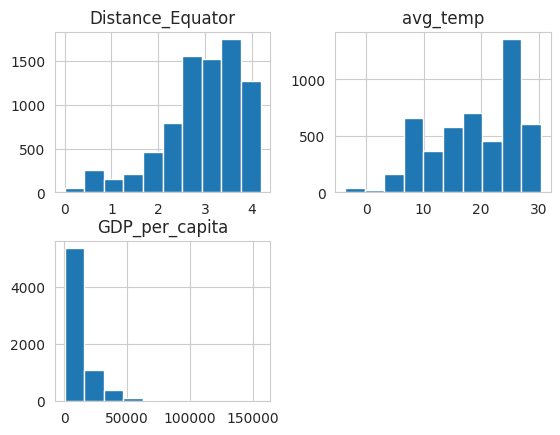

In [723]:
data[['Distance_Equator', 'avg_temp', 'GDP_per_capita']].hist();

#### GDP_per_capita would benefit from log transform

In [724]:
data = functions.log_transform_data(data, ['Cereal_Yield', 'Arable_Land_Percent', 'Value_Added_AFF',
                                                 'Arable_Land_Person', 'Freshwater_Withdrawl', 'Fertilizer',
                                                 'Education_Expenditure', 'Natural_Resource_Rents', 'Country_Name',
                                                 'Country_Code', 'Year', 'Distance_Equator', 'avg_temp'])

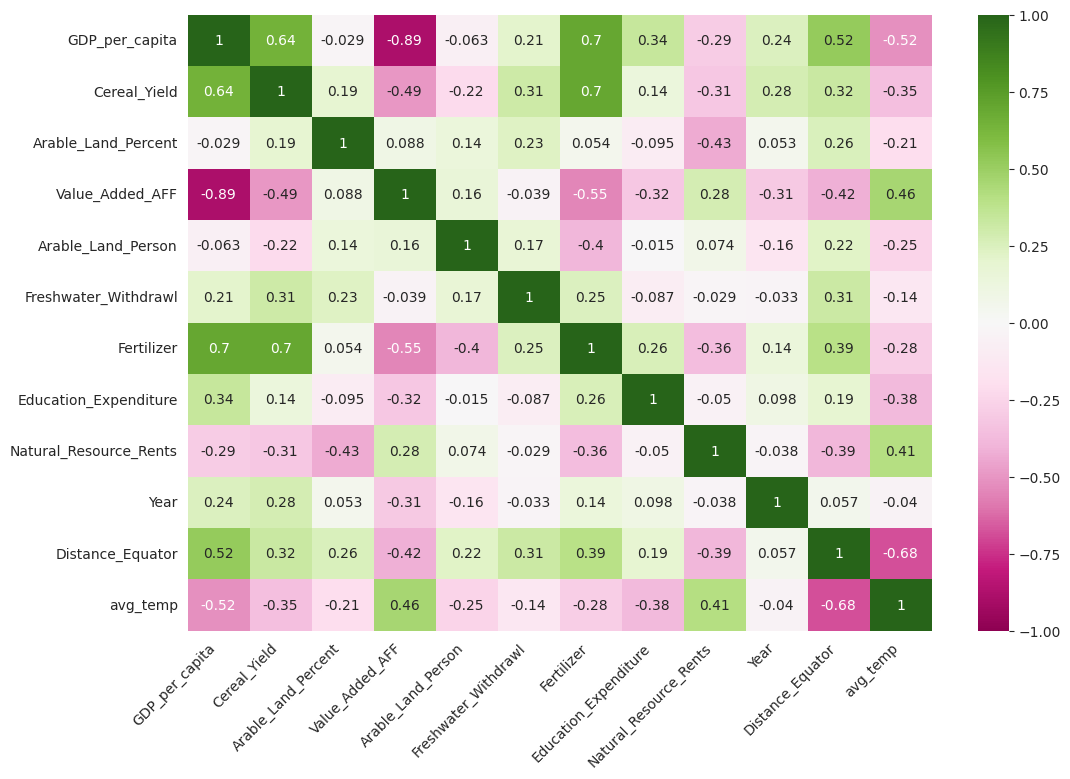

In [725]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG')
plt.xticks(rotation = 45, ha = 'right');

#### We will drop the Value_Added_AFF variable given high -ve correlation with GDP_per_capita and given that GDP_per_capita has a higher correlation with target

In [726]:
data = data.drop(columns = ['Value_Added_AFF'])

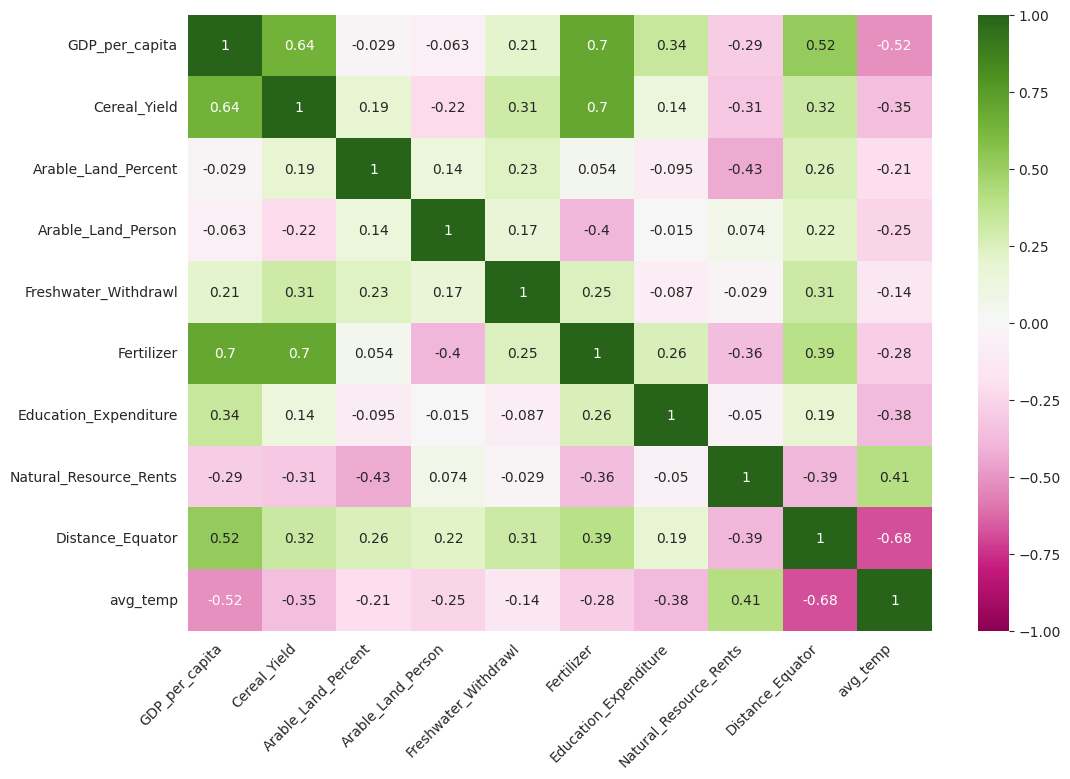

In [727]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(data.drop(columns = ['Year']).corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG')
plt.xticks(rotation = 45, ha = 'right');

### Explore the variation of variables within each countries series

In [728]:
data.groupby('Country_Name')[['GDP_per_capita', 'Arable_Land_Percent', 'Arable_Land_Person', 
                              'Freshwater_Withdrawl', 'Fertilizer', 'Education_Expenditure', 
                              'Natural_Resource_Rents', 'avg_temp', 'Cereal_Yield']].var().mean().sort_values()

Arable_Land_Person        0.002963
Freshwater_Withdrawl      0.027369
Arable_Land_Percent       0.034522
Education_Expenditure     0.052631
Cereal_Yield              0.116856
GDP_per_capita            0.145056
Natural_Resource_Rents    0.167472
avg_temp                  0.308130
Fertilizer                0.415389
dtype: float64

#### I will drop Arable Land Per Person

In [729]:
data = data.drop(columns = ['Arable_Land_Person'])

# Some visualisations

In [730]:
sns.set_style('whitegrid')

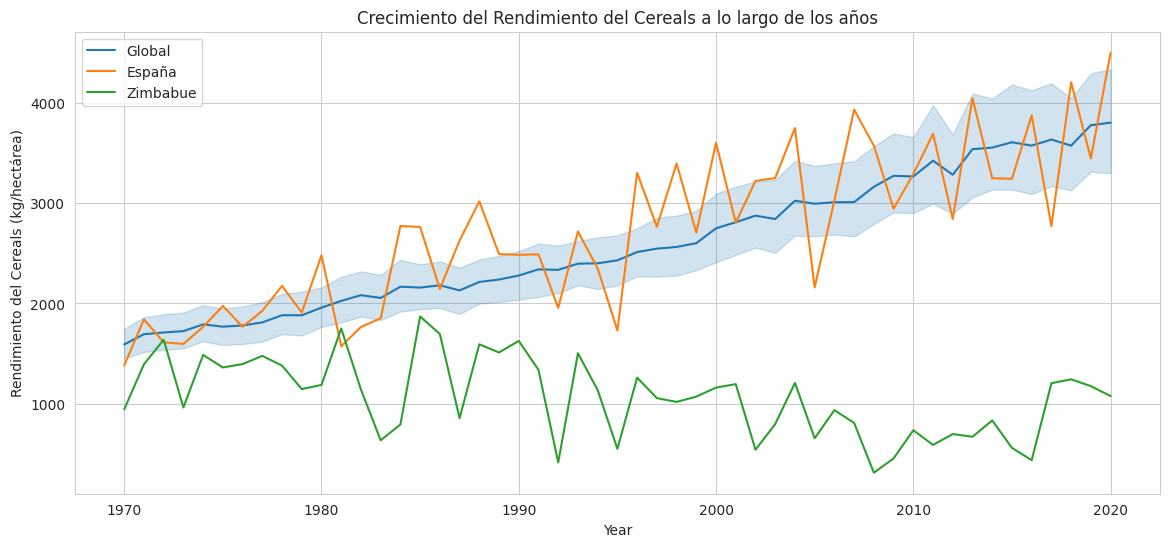

In [731]:
fig, ax = plt.subplots(figsize = (14, 6), sharey = True)

sns.lineplot(data = data, x = 'Year', y = np.exp(data['Cereal_Yield']), label = 'Global')
ax.set_ylabel('Rendimiento del Cereals (kg/hectárea)')
ax.set_title('Crecimiento del Rendimiento del Cereals a lo largo de los años')

sns.lineplot(data = data[data['Country_Name'] == 'Spain'], x = 'Year', y = np.exp(data['Cereal_Yield']), label = 'España')
sns.lineplot(data = data[data['Country_Name'] == 'Zimbabwe'], x = 'Year', y = np.exp(data['Cereal_Yield']), label = 'Zimbabue');

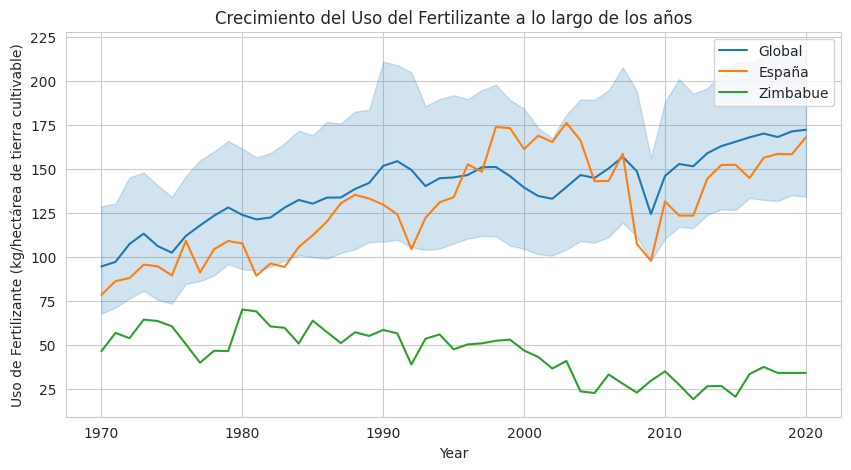

In [732]:
fig, ax = plt.subplots(figsize = (10, 5), sharey = True)

sns.lineplot(data = data, x = 'Year', y = np.exp(data['Fertilizer']), label = 'Global')
ax.set_ylabel('Uso de Fertilizante (kg/hectárea de tierra cultivable)')
ax.set_title('Crecimiento del Uso del Fertilizante a lo largo de los años')

sns.lineplot(data = data[data['Country_Name'] == 'Spain'], x = 'Year', y = np.exp(data['Fertilizer']), label = 'España')
sns.lineplot(data = data[data['Country_Name'] == 'Zimbabwe'], x = 'Year', y = np.exp(data['Fertilizer']), label = 'Zimbabue');

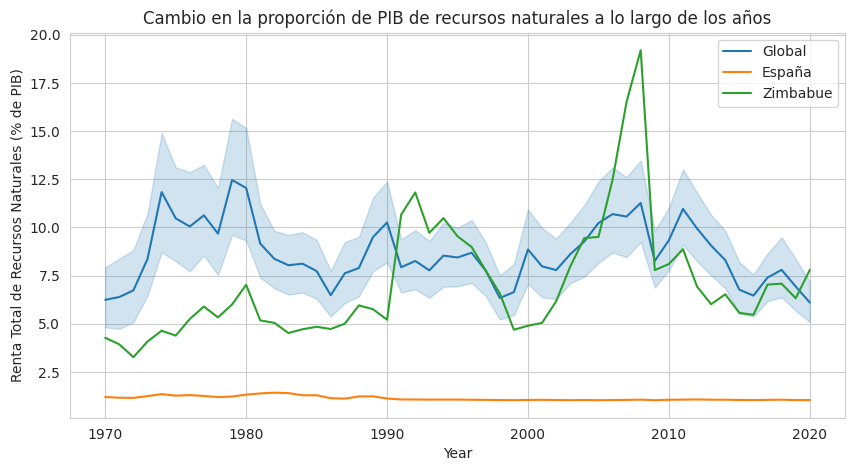

In [733]:
fig, ax = plt.subplots(figsize = (10, 5), sharey = True)

sns.lineplot(data = data, x = 'Year', y = np.exp(data['Natural_Resource_Rents']), label = 'Global')
ax.set_ylabel('Renta Total de Recursos Naturales (% de PIB)')
ax.set_title('Cambio en la proporción de PIB de recursos naturales a lo largo de los años')

sns.lineplot(data = data[data['Country_Name'] == 'Spain'], x = 'Year', y = np.exp(data['Natural_Resource_Rents']), label = 'España')
sns.lineplot(data = data[data['Country_Name'] == 'Zimbabwe'], x = 'Year', y = np.exp(data['Natural_Resource_Rents']), label = 'Zimbabue');

Text(0.5, 0, 'log(GDP per capita)')

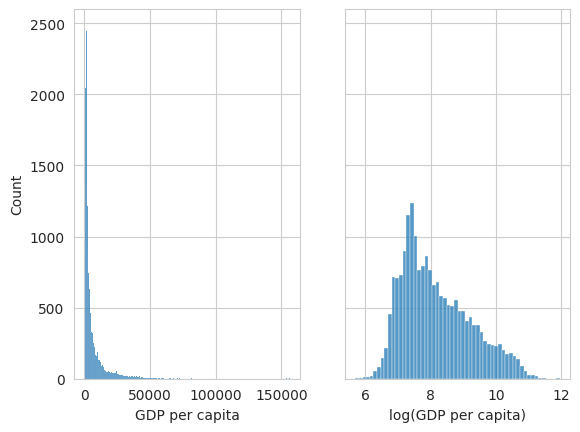

In [734]:
fig, ax = plt.subplots(1, 2, sharey = True)
sns.histplot(data = historical_gdp, x = 'GDP per capita', ax = ax[0])
sns.histplot(data = historical_gdp, x = np.log1p(historical_gdp['GDP per capita']), ax = ax[1])
ax[1].set_xlabel('log(GDP per capita)')

Text(0.5, 0, 'log(Cereal yield (kg per hectare))')

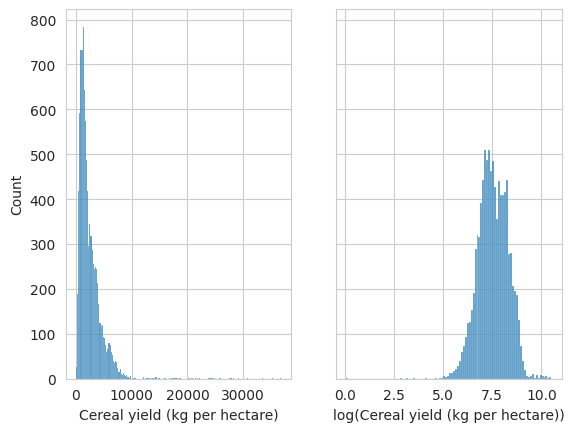

In [735]:
fig, ax = plt.subplots(1, 2, sharey = True)
sns.histplot(data = wb_df, x = 'Cereal yield (kg per hectare)', ax = ax[0])
sns.histplot(data = historical_gdp, x = np.log1p(wb_df['Cereal yield (kg per hectare)']), ax = ax[1])
ax[1].set_xlabel('log(Cereal yield (kg per hectare))')

# Create Time Lag Features by Country
#### We want a time horizon of 5 years so do shift of 5

In [736]:
def create_time_lag(col: str, df: pd.DataFrame, lags: list):
    for lag in lags:
        df[f'{col}_{lag}'] = df.groupby('Country_Name')[col].shift(lag)
    return df

In [737]:
def plot_variable_target(variable: str, df: pd.DataFrame, country = 'China'):
    
    fig, ax = plt.subplots()
    
    df_subset = df[df['Country_Name'] == country]
    
    variable_data = df_subset[variable] - df_subset[variable].mean()
    target_data = df_subset['Cereal_Yield'] - df_subset['Cereal_Yield'].mean()
    
    sns.lineplot(data = df_subset, x = 'Year', y = variable_data, label = variable)
    sns.lineplot(data = df_subset, x = 'Year', y = target_data, label = 'Cereal_Yield')
    plt.show()

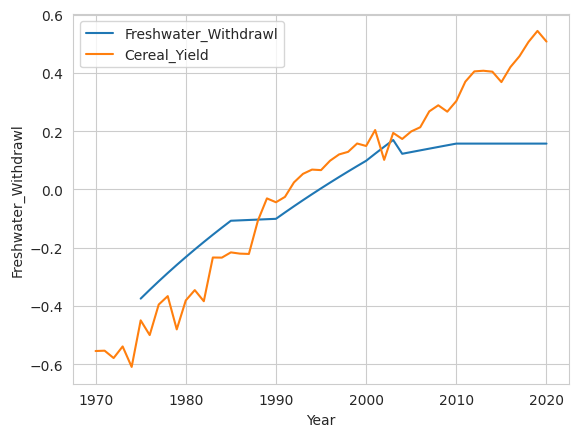

In [738]:
plot_variable_target('Freshwater_Withdrawl', data, 'India')

#### Use a time lag of 5 years

In [739]:
data = create_time_lag('Freshwater_Withdrawl', data, [5])

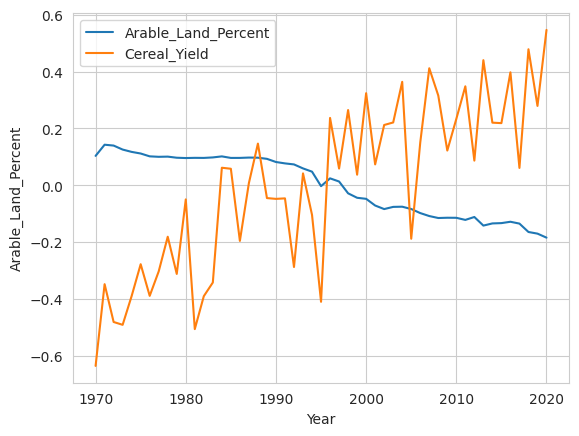

In [740]:
plot_variable_target('Arable_Land_Percent', data, 'Spain')

In [741]:
data = create_time_lag('Arable_Land_Percent', data, [5])

#### No time lag

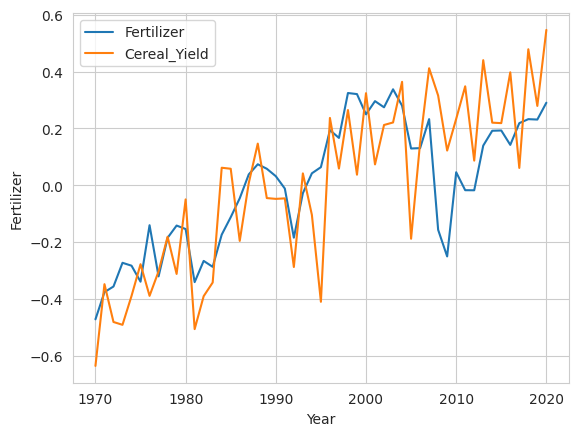

In [742]:
plot_variable_target('Fertilizer', data, 'Spain')

In [743]:
data = create_time_lag('Fertilizer', data, [5])

#### Fertilizer appears to be stongly and immediately correlated with yield - no time lag

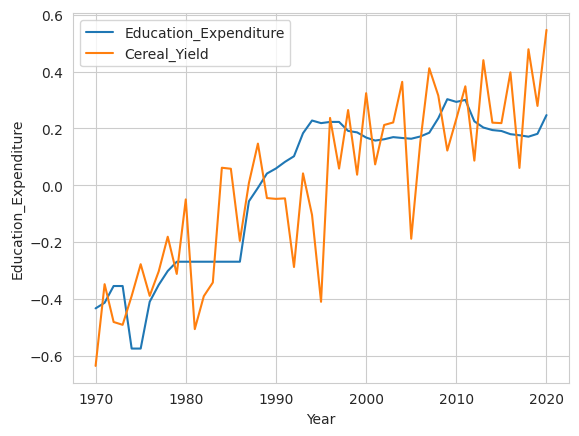

In [744]:
plot_variable_target('Education_Expenditure', data, 'Spain')

#### Education expenditure likely takes aound 10 years to bear fruit

In [745]:
data = create_time_lag('Education_Expenditure', data, [5])

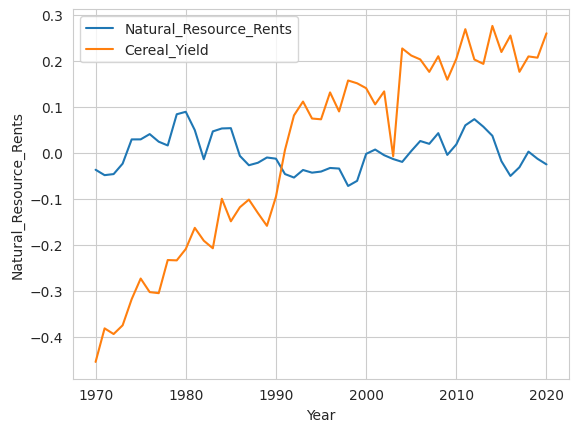

In [746]:
plot_variable_target('Natural_Resource_Rents', data, 'Italy')

#### Flucuations but no clear lag - try 1, 2 and 3

In [747]:
data = create_time_lag('Natural_Resource_Rents', data, [5])

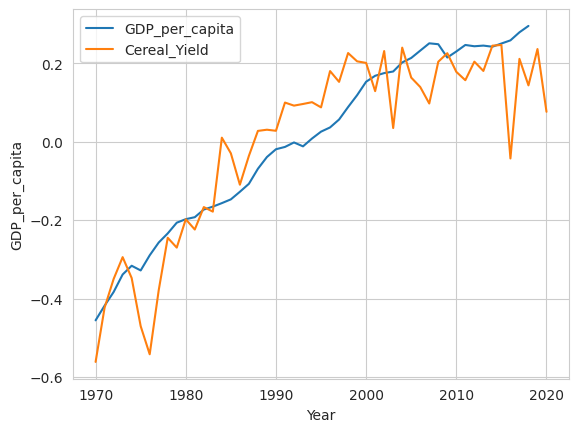

In [748]:
plot_variable_target('GDP_per_capita', data, 'France')

#### GDP likely plays out on a year or two delay

In [749]:
data = create_time_lag('GDP_per_capita', data, [5])

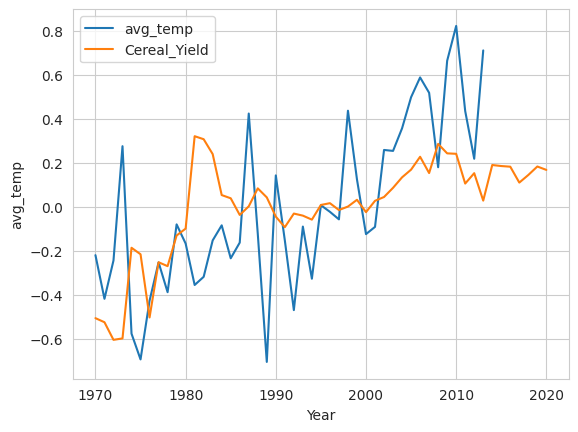

In [750]:
plot_variable_target('avg_temp', data, 'Nigeria')

In [751]:
data = create_time_lag('avg_temp', data, [5])

#### In hot countries, the heatwaves knock out crops immediately - there is no lag here

#### We will also create lags of the cereal yield itself

In [752]:
data = create_time_lag('Cereal_Yield', data, [5])

#### So we have all the primary data prepared and ready to create the models

In [754]:
data.to_parquet('./data/data_for_model.parquet')

In [756]:
data_lag = data.drop(columns = ['GDP_per_capita', 'Arable_Land_Percent', 'Freshwater_Withdrawl', 'Fertilizer', 'Education_Expenditure', 'Natural_Resource_Rents', 'avg_temp'])

In [759]:
data_lag = data_lag[data_lag['Year'] > 1974]

# Split Train Test before all Model Building

In [763]:
X_train = data_lag[data_lag['Year'] < 2016].drop(columns = ['Country_Code', 'Cereal_Yield'])
X_test = data_lag[data_lag['Year'] > 2015].drop(columns = ['Country_Code', 'Cereal_Yield'])
y_train = data_lag[data_lag['Year'] < 2016]['Cereal_Yield']
y_test = data_lag[data_lag['Year'] > 2015]['Cereal_Yield']

In [764]:
X_train.head()

,Country_Name,Year,Distance_Equator,Freshwater_Withdrawl_5,Arable_Land_Percent_5,Fertilizer_5,Education_Expenditure_5,Natural_Resource_Rents_5,GDP_per_capita_5,avg_temp_5,Cereal_Yield_5
5,Afghanistan,1975,3.526361,NaN,2.570036,1.242729,NaN,0.264578,7.149132,15.22,7.008596
6,Afghanistan,1976,3.526361,NaN,2.573550,1.279526,0.770275,0.317694,7.121252,15.10,6.884691
7,Afghanistan,1977,3.526361,NaN,2.574719,1.543331,0.750085,0.361316,6.915723,13.46,6.915624
8,Afghanistan,1978,3.526361,NaN,2.574719,1.413420,0.887018,0.626513,6.919684,14.43,7.155084
9,Afghanistan,1979,3.526361,NaN,2.574719,1.665008,0.887018,0.766010,6.946976,13.95,7.172348


In [765]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6652, 11) (887, 11) (6652,) (887,)


#### I need to do a backfill on the Education Expenditure as the KNN impute won't work

In [766]:
cols_to_bfill = ['Education_Expenditure_5', 'Freshwater_Withdrawl_5', 'Natural_Resource_Rents_5', 'Cereal_Yield_5', 'GDP_per_capita_5', 'avg_temp_5', 'Arable_Land_Percent_5']

In [767]:
X_train = X_train.sort_values(by = ['Country_Name', 'Year'])

for col in X_train[cols_to_bfill].columns:
    if X_train[col].dtype == 'float64':
        X_train[col] = X_train.groupby('Country_Name')[col].transform(lambda x: x.bfill())

In [768]:
X_test = X_test.sort_values(by = ['Country_Name', 'Year'])

for col in X_test[cols_to_bfill].columns:
    if X_test[col].dtype == 'float64':
        X_test[col] = X_test.groupby('Country_Name')[col].transform(lambda x: x.bfill())

In [769]:
X_train = X_train.drop(columns = ['Country_Name', 'Year'])
X_test = X_test.drop(columns = ['Country_Name', 'Year'])

# Random Forest Regression

In [774]:
results = []

for k in np.arange(1, 10, 1):
    print('k:', k)
    pipe = Pipeline([('knn_imputer', KNNImputer()),
                ('scaler', StandardScaler()), 
                ('selectk', SelectKBest(k = k)), 
                ('rf_reg', RandomForestRegressor(max_depth = 8))])
    
    pipe.fit(X_train, y_train)
    
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    results.append([k, mape_test, mape_train])

k: 1
k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9


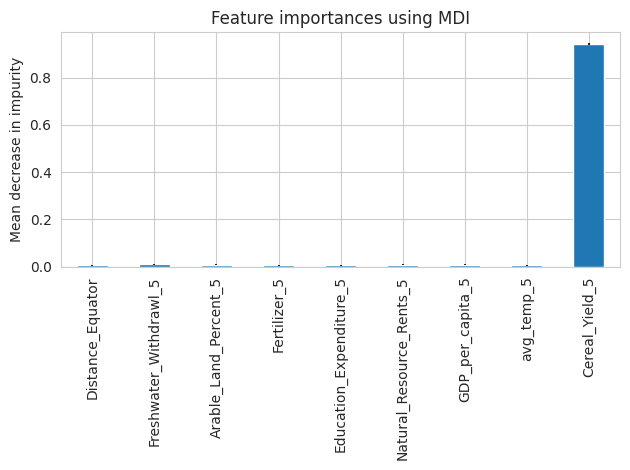

In [776]:
importances = pipe['rf_reg'].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe['rf_reg'].estimators_], axis = 0)

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [777]:
results_kbest = pd.DataFrame(results, columns = ['K Best', 'MAPE Test', 'MAPE Train'])
results_kbest['K Best'] = results_kbest['K Best'].astype(str)

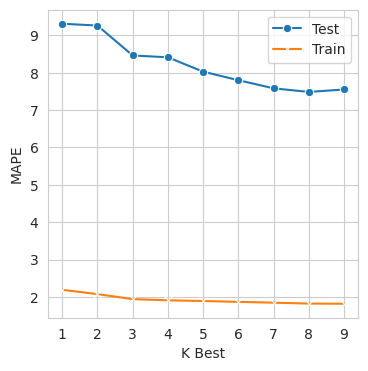

In [778]:
fig, ax = plt.subplots(figsize = (4, 4))
sns.lineplot(data = results_kbest, x = 'K Best', y = 'MAPE Test', marker = "o", label = 'Test')
ax.set_ylabel('MAPE')
sns.lineplot(data = results_kbest, x = 'K Best', y = 'MAPE Train', marker = "x", label = 'Train');

In [ ]:
pipe = Pipeline([('knn_imputer', KNNImputer()),
                ('scaler', StandardScaler()), 
                ('selectk', SelectKBest(k = 9)), 
                ('rf_reg', RandomForestRegressor(max_depth = 8))])
    
pipe.fit(X_train, y_train)
mask = pipe['selectk'].get_support()
new_features = X_train.columns[mask]
new_features

Index(['GDP_per_capita', 'Freshwater_Withdrawl', 'Freshwater_Withdrawl_5',
       'GDP_per_capita_1', 'GDP_per_capita_2', 'GDP_per_capita_3',
       'Cereal_Yield_1', 'Cereal_Yield_2'],
      dtype='object')

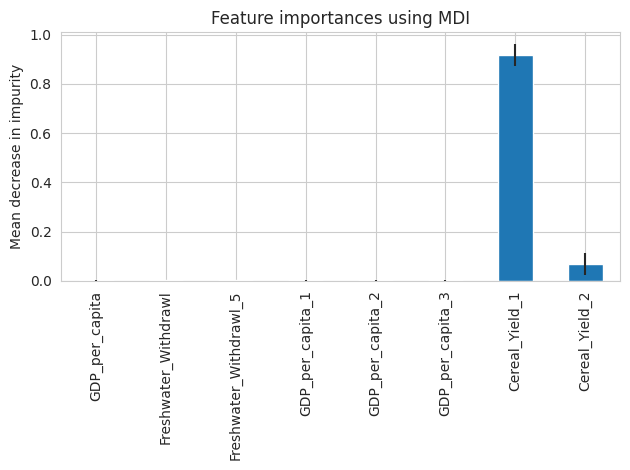

In [ ]:
importances = pipe['rf_reg'].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe['rf_reg'].estimators_], axis = 0)

forest_importances = pd.Series(importances, index=new_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [782]:
results = []

for max_d in np.arange(2, 22, 4):
    print('max_d:', max_d)
    pipe = Pipeline([('knn_imputer', KNNImputer()),
                ('scaler', StandardScaler()), 
                ('selectk', SelectKBest(k = 8)), 
                ('rf_reg', RandomForestRegressor(max_depth = max_d))])
    
    pipe.fit(X_train, y_train)
    
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    results.append([max_d, mape_test, mape_train])

max_d: 2
max_d: 6
max_d: 10
max_d: 14
max_d: 18


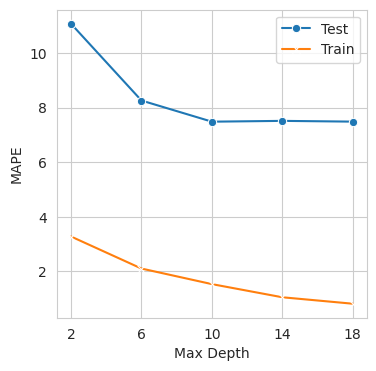

In [783]:
results_max_d = pd.DataFrame(results, columns = ['Max Depth', 'MAPE Test', 'MAPE Train'])
results_max_d['Max Depth'] = results_max_d['Max Depth'].astype(str)

fig, ax = plt.subplots(figsize = (4, 4))
sns.lineplot(data = results_max_d, x = 'Max Depth', y = 'MAPE Test', marker = "o", label = 'Test')
ax.set_ylabel('MAPE')
sns.lineplot(data = results_max_d, x = 'Max Depth', y = 'MAPE Train', marker = "x", label = 'Train');

In [784]:
results = []

for max_d in np.arange(2, 22, 4):
    print('max_d:', max_d)
    for k in np.arange(1, 10, 2):
        pipe = Pipeline([('knn_imputer', KNNImputer()),
                        ('poly_feat', PolynomialFeatures(2)), 
                        ('scaler', StandardScaler()), 
                        ('selectk', SelectKBest(k = k)), 
                        ('rf_reg', RandomForestRegressor(max_depth = max_d))])
        
        pipe.fit(X_train, y_train)
        
        y_pred_test = pipe.predict(X_test)
        y_pred_train = pipe.predict(X_train)
        
        mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
        
        results.append([max_d, k, mape_test, mape_train])

max_d: 2


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

max_d: 6


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

max_d: 10


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

max_d: 14


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

max_d: 18


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

In [785]:
results_poly = pd.DataFrame(results, columns = ['Max Depth', 'K Best', 'MAPE Test', 'MAPE Train'])
results_poly['Max Depth'] = results_poly['Max Depth'].astype(str)
results_poly['K Best'] = results_poly['K Best'].astype(str)


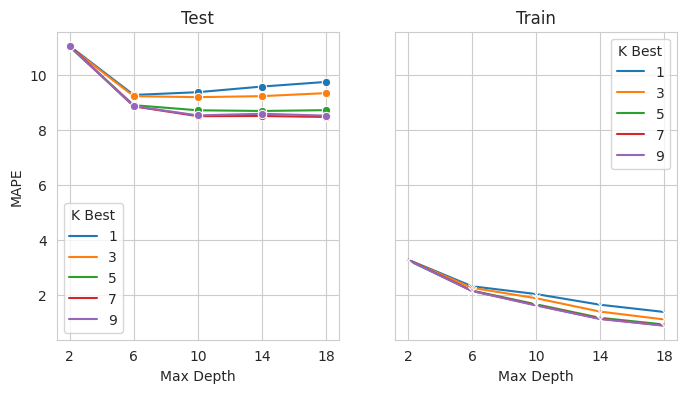

In [786]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4), sharey = True)
sns.lineplot(data = results_poly, x = 'Max Depth', y = 'MAPE Test', marker = "o", hue = 'K Best', ax = ax[0])
ax[0].set_ylabel('MAPE')
ax[0].set_title('Test')
sns.lineplot(data = results_poly, x = 'Max Depth', y = 'MAPE Train', marker = "x", hue = 'K Best', ax = ax[1])
ax[1].set_title('Train');

### Final model gridsearch

In [787]:
pipe = Pipeline([('knn_imputer', KNNImputer()),
                 ('scaler', StandardScaler()), 
                 ('selectk', SelectKBest()), 
                 ('rf_reg', RandomForestRegressor())])

pipe_param = {
    "selectk__k" : np.arange(1, 10, 2),
    'rf_reg__max_depth': [6, 9, 12, 15],
    'rf_reg__min_samples_split': [2, 4]
}

cv = TimeSeriesSplit(n_splits=3)

gs_pipe = GridSearchCV(pipe,
                        pipe_param,
                        cv = cv,
                        scoring = 'neg_mean_absolute_percentage_error',
                        verbose = 2,
                        n_jobs = -1,
                        error_score = 0.0)

In [788]:
gs_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=1; total time=   2.4s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=3; total time=   3.4s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=1; total time=   5.0s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=3; total time=   4.9s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=5; total time=   2.8s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=1; total time=   9.0s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=7; total time=   2.5s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=3; total time=   9.3s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=5; total time=   6.7s
[CV] END rf_reg__max_depth=6, rf_reg__min_samples_split=2, selectk__k=5; total time=   8.7s
[CV] END rf_reg__m

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             error_score=0.0,
             estimator=Pipeline(steps=[('knn_imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('selectk', SelectKBest()),
                                       ('rf_reg', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf_reg__max_depth': [6, 9, 12, 15],
                         'rf_reg__min_samples_split': [2, 4],
                         'selectk__k': array([1, 3, 5, 7, 9])},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [789]:
best_estimator_cv = gs_pipe.best_estimator_

best_estimator_full = clone(gs_pipe.best_estimator_)
best_estimator_full.fit(X_train, y_train)

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('selectk', SelectKBest(k=1)),
                ('rf_reg', RandomForestRegressor(max_depth=6))])

In [790]:
y_pred_test_cv = pd.Series(best_estimator_cv.predict(X_test), name = 'Predictions_Test_CV')
y_pred_train_cv = pd.Series(best_estimator_cv.predict(X_train), name = 'Predictions_Train_CV')

y_pred_test_full = pd.Series(best_estimator_full.predict(X_test), name = 'Predictions_Test_Full')
y_pred_train_full = pd.Series(best_estimator_full.predict(X_train), name = 'Predictions_Train_Full')

In [791]:
mape_test_cv = mean_absolute_percentage_error(y_test, y_pred_test_cv) * 100
mape_train_cv = mean_absolute_percentage_error(y_train, y_pred_train_cv) * 100

mape_test_full = mean_absolute_percentage_error(y_test, y_pred_test_full) * 100
mape_train_full = mean_absolute_percentage_error(y_train, y_pred_train_full) * 100

In [792]:
print('MAPE Test CV Model:', mape_test_cv)
print('MAPE Train CV Model:', mape_train_cv)

print('MAPE Test Full Model:', mape_test_full)
print('MAPE Train Full Model:', mape_train_full)

MAPE Test CV Model: 9.271460568480176
MAPE Train CV Model: 2.3133457222918787
MAPE Test Full Model: 9.286358896993505
MAPE Train Full Model: 2.311473960690141


In [793]:
mape_test_cv_exp = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test_cv)) * 100
mape_train_cv_exp = mean_absolute_percentage_error(np.exp(y_train), np.exp(y_pred_train_cv)) * 100

mape_test_full_exp = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred_test_full)) * 100
mape_train_full_exp = mean_absolute_percentage_error(np.exp(y_train), np.exp(y_pred_train_full)) * 100

In [794]:
print('MAPE Test CV Model:', mape_test_cv_exp)
print('MAPE Train CV Model:', mape_train_cv_exp)

print('MAPE Test Full Model:', mape_test_full_exp)
print('MAPE Train Full Model:', mape_train_full_exp)

MAPE Test CV Model: 60.96133934567085
MAPE Train CV Model: 17.77902272099562
MAPE Test Full Model: 61.60855697381565
MAPE Train Full Model: 17.78403980789626


In [795]:
X_test_year_country = data[data['Year'] > 2014][['Year', 'Country_Name']].reset_index(drop = True)
y_test = y_test.reset_index(drop = True)
test_predictions_df = pd.concat([X_test_year_country, np.exp(y_test), np.exp(y_pred_test_cv), np.exp(y_pred_test_full)], axis = 1)

In [796]:
test_predictions_df['Absolute_Percent_Error'] = (abs(test_predictions_df['Cereal_Yield'] - test_predictions_df['Predictions_Test_CV']) / test_predictions_df['Cereal_Yield']) * 100

In [797]:
test_predictions_df[test_predictions_df['Country_Name'] == 'China']

,Year,Country_Name,Cereal_Yield,Predictions_Test_CV,Predictions_Test_Full,Absolute_Percent_Error
198,2015,China,2265.3,2371.117766,2365.020136,4.671247
199,2016,China,2211.9,2378.844912,2368.556565,7.547580
200,2017,China,6666.5,5550.682911,5544.405653,16.737675
201,2018,China,5705.8,4669.314396,4697.399216,18.165474
202,2019,China,7056.6,5556.100155,5572.269414,21.263779
203,2020,China,7158.3,6155.812253,6259.228719,14.004551


Text(0.5, 0, 'Absolute Percent Error')

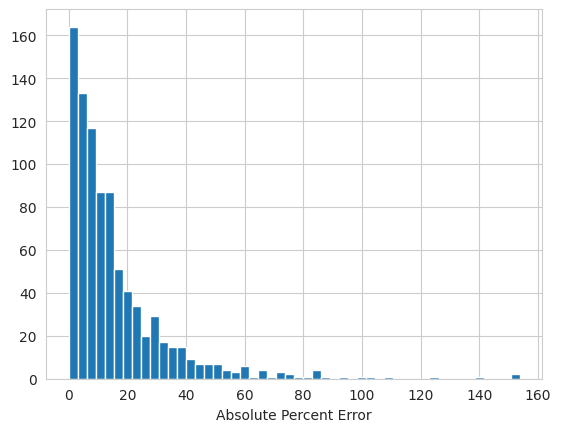

In [798]:
test_predictions_df[test_predictions_df['Absolute_Percent_Error'] < 200]['Absolute_Percent_Error'].hist(bins = 50)
plt.xlabel("Absolute Percent Error")

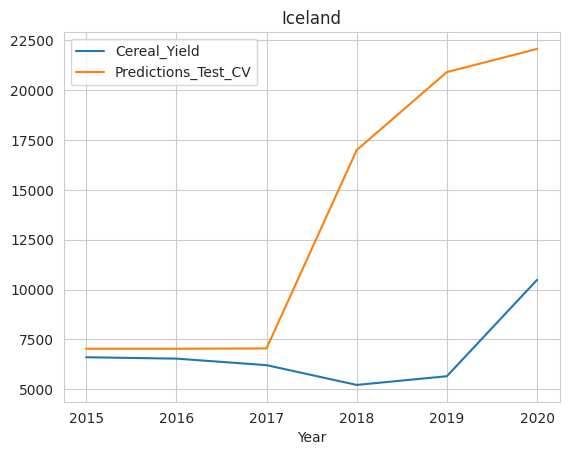

In [815]:
test_predictions_df[test_predictions_df['Country_Name'] == 'Iceland'][['Year', 'Cereal_Yield', 'Predictions_Test_CV']].plot(x = 'Year')
plt.title("Iceland");

In [811]:
test_predictions_df.groupby('Country_Name')[['Cereal_Yield', 'Absolute_Percent_Error']].mean().sort_values(by = 'Absolute_Percent_Error', ascending = False)

,Cereal_Yield,Absolute_Percent_Error
Country_Name,,
Brazil,898.950000,5541.787763
Brunei Darussalam,1815.766667,1018.462455
Iceland,6787.266667,105.458638
Comoros,2439.950000,102.116400
Lebanon,724.550000,69.280152
...,...,...
Vietnam,NaN,NaN
West Bank and Gaza,NaN,NaN
"Yemen, Rep.",NaN,NaN


In [817]:
test_predictions_df[~test_predictions_df['Country_Name'].isin(['Brazil', 'Brunei Darussalam'])].mean()

/home/sean/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Year                      2017.495726
Cereal_Yield              3705.621600
Predictions_Test_CV       3560.460313
Predictions_Test_Full     3574.396305
Absolute_Percent_Error      16.812808
dtype: float64

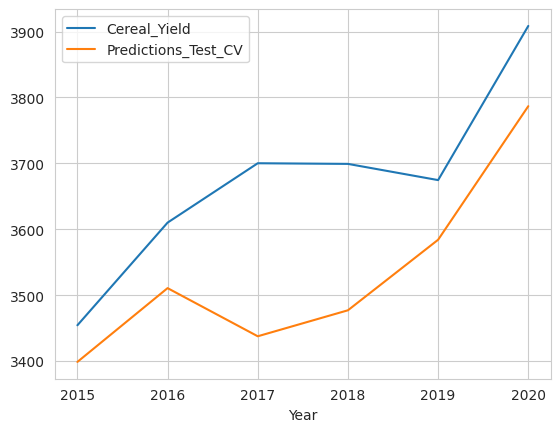

In [804]:
test_predictions_df.groupby('Year')[['Cereal_Yield', 'Predictions_Test_CV']].mean().plot();